# Технологии обработки больших данных

Занятие 3. PySpark Data Structures

0. Запуск PySpark на локальной машине
1. Spark DataFrame
2. Spark RDD (разбор предыдущего ДЗ)
3. Spark Pandas API DataFrame
4. Домашнее задание

In [49]:
%%bash
pip install pandas pyarrow plotly

In [50]:
! pip install pyspark

In [51]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Рассмотрим пример данных [German Credit](https://www.kaggle.com/uciml/german-credit), которые используются для решении задачи кредитного скоринга. Это небольшой датасет с информацией о клиентах, необходимой для принятия решения - выдавать кредит или нет.  

Сегодня мы не будем решать задачу предсказания, просто разберемся с основными приемами EDA (Exploratory data analysis, [Разведочный анализ данных](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D0%B4%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)).

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
DATA_PATH = '/content/drive/My Drive/german_credit_data.csv'

**Columns**  

Age (numeric)  
Sex (text: male, female)  
Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)  
Housing (text: own, rent, or free)  
Saving accounts (text - little, moderate, quite rich, rich)  
Checking account (numeric, in DM - Deutsch Mark)  
Credit amount (numeric, in DM)  
Duration (numeric, in month)  
Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

## 1. Spark DataFrame

Базовый класс для работы со структуированными данными в pyspark.

In [54]:
df = spark.read.csv(DATA_PATH, header=True)
type(df)

pyspark.sql.dataframe.DataFrame

In [55]:
# First rows in this DataFrame
df.show(10, truncate=False)

+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
|_c0|Age|Sex   |Job|Housing|Saving accounts|Checking account|Credit amount|Duration|Purpose            |
+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
|0  |67 |male  |2  |own    |NA             |little          |1169         |6       |radio/TV           |
|1  |22 |female|2  |own    |little         |moderate        |5951         |48      |radio/TV           |
|2  |49 |male  |1  |own    |little         |NA              |2096         |12      |education          |
|3  |45 |male  |2  |free   |little         |little          |7882         |42      |furniture/equipment|
|4  |53 |male  |2  |free   |little         |little          |4870         |24      |car                |
|5  |35 |male  |1  |free   |NA             |NA              |9055         |36      |education          |
|6  |53 |male  |2  |own    |quite rich     |NA         

### Схема данных как в SQL

In [56]:
schema = "id INT, Age INT, Sex STRING, Job INT, Housing STRING, Saving_accounts STRING, \
Checking_account STRING, Credit_amount INT, Duration INT, Purpose STRING"

In [57]:
df = spark.read.csv( '/content/drive/My Drive/german_credit_data.csv', schema=schema, header=True )

In [58]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Job: integer (nullable = true)
 |-- Housing: string (nullable = true)
 |-- Saving_accounts: string (nullable = true)
 |-- Checking_account: string (nullable = true)
 |-- Credit_amount: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Purpose: string (nullable = true)



### Сортировка и фильтрация данных

In [59]:
# One column sorting
df.sort('Job', ascending=False).show()

+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
| id|Age|   Sex|Job|Housing|Saving_accounts|Checking_account|Credit_amount|Duration|            Purpose|
+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
| 56| 52|  male|  3|    own|             NA|        moderate|         6468|      12|           radio/TV|
|175| 53|female|  3|    own|             NA|              NA|         7485|      30|                car|
| 58| 23|female|  3|    own|         little|            rich|         1961|      18|                car|
|  9| 28|  male|  3|    own|         little|        moderate|         5234|      30|                car|
| 62| 61|  male|  3|   free|         little|        moderate|         1953|      36|           business|
| 51| 30|  male|  3|    own|         little|        moderate|         5965|      27|                car|
| 72| 51|  male|  3|   free|         little|          l

In [60]:
# Few columns sorting
df.sort(['Age', 'Credit_amount'], ascending=[False, True]).show()

+---+---+------+---+-------+---------------+----------------+-------------+--------+---------+
| id|Age|   Sex|Job|Housing|Saving_accounts|Checking_account|Credit_amount|Duration|  Purpose|
+---+---+------+---+-------+---------------+----------------+-------------+--------+---------+
|536| 75|female|  3|    own|             NA|          little|         1374|       6|      car|
|330| 75|  male|  3|   free|         little|          little|         6615|      24|      car|
|756| 74|  male|  0|    own|         little|            rich|         1299|       6|      car|
|430| 74|  male|  1|    own|         little|              NA|         3448|       5| business|
|606| 74|  male|  3|    own|         little|              NA|         4526|      24| business|
|186| 74|female|  3|   free|         little|        moderate|         5129|       9|      car|
|163| 70|  male|  3|   free|         little|        moderate|         7308|      10|      car|
|187| 68|  male|  0|   free|         little|      

In [61]:
df_car = df.filter(df["Purpose"] == 'car')

In [62]:
# Доля автокредитов
df_car.count() / df.count()

0.337

### Группировка данных

In [63]:
df.groupBy("Age").count().sort('Age').show()

+---+-----+
|Age|count|
+---+-----+
| 19|    2|
| 20|   14|
| 21|   14|
| 22|   27|
| 23|   48|
| 24|   44|
| 25|   41|
| 26|   50|
| 27|   51|
| 28|   43|
| 29|   37|
| 30|   40|
| 31|   38|
| 32|   34|
| 33|   33|
| 34|   32|
| 35|   40|
| 36|   39|
| 37|   29|
| 38|   24|
+---+-----+
only showing top 20 rows



## 2. Spark RDD

Resilient Distributed Dataset.
Менее удобный, но более производительный контейнер для данных.  

Подробнее про DataFrame, DataSet и RDD на русском языке
[1](https://www.bigdataschool.ru/blog/spark-sql-data-structures.html),
[2](https://www.bigdataschool.ru/blog/rdd-vs-dataframe-vs-dataset.html).  

На английском рекомендую [официальный гайд](https://spark.apache.org/docs/latest/sql-getting-started.html).

In [64]:
import random, string, datetime
letters = string.ascii_lowercase

LOG_SIZE = 10*24*365 # 87600

def get_random_word(length=3):
   return ''.join(random.choice(letters) for i in range(length))

def get_line(length=100):
  t = str(datetime.datetime.now())
  words = [get_random_word() for n in range(length)]
  return t + ' ' + ' '.join(w for w in words) + '\n'

lines = [get_line() for l in range(LOG_SIZE)]

with open('log.txt', 'w') as f:
  f.writelines(lines)

In [65]:
log_file = spark.read.text('log.txt')

In [66]:
%%time

# Note, we cant use   lambda x:   x.value.upper()
df = log_file.rdd.map(lambda x: ( x.value.upper() ,) ).toDF()

df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_1                                                                                                                                                                                                                                                                                                                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------

In [67]:
with open('white_list.txt') as f:
    ww = f.readlines()

ww = "".join([w for w in ww]).split()
ww = list(map(str.lower, ww))

In [68]:
def white_filter(s):
    w = s.value.split()
    timestamp = str(w[0]) + str(w[1]) + " "
    words = w[2:]
    filtered_words = list(filter(lambda x: x in ww, words))
    return (timestamp, " ".join([w for w in filtered_words])  )

In [69]:
%%time
df2 = log_file.rdd.map(white_filter).toDF(schema=('TimeStamp', 'Words'))
df2.show(truncate=False)

+--------------------------+-----------+
|TimeStamp                 |Words      |
+--------------------------+-----------+
|2025-05-1618:55:51.245685 |           |
|2025-05-1618:55:51.246027 |           |
|2025-05-1618:55:51.246291 |           |
|2025-05-1618:55:51.246576 |           |
|2025-05-1618:55:51.246848 |           |
|2025-05-1618:55:51.247127 |had        |
|2025-05-1618:55:51.247388 |lot        |
|2025-05-1618:55:51.251339 |mad        |
|2025-05-1618:55:51.251646 |           |
|2025-05-1618:55:51.251947 |           |
|2025-05-1618:55:51.252271 |job not his|
|2025-05-1618:55:51.252570 |few        |
|2025-05-1618:55:51.252829 |dug        |
|2025-05-1618:55:51.253138 |dab mum    |
|2025-05-1618:55:51.253466 |got        |
|2025-05-1618:55:51.253766 |let dab    |
|2025-05-1618:55:51.254093 |           |
|2025-05-1618:55:51.254368 |you        |
|2025-05-1618:55:51.254672 |not        |
|2025-05-1618:55:51.254918 |           |
+--------------------------+-----------+
only showing top

In [70]:
wordCounts = df2.rdd.flatMap(lambda line: line[1].split(" "))\
                      .map(lambda word: (word, 1))\
                      .reduceByKey(lambda a, b: a + b)

In [71]:
%%time
wordCounts.toDF().show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

## 3. Spark Pandas API

Начиная с версии Spark 3.2 имеется реализация Pandas API.    
Хороший материал непосредственно по pandas: [mlcourse.ai](https://habr.com/ru/company/ods/blog/322626/)

In [74]:
# import pandas as pd

import pandas as pd

In [ ]:
!pip uninstall numpy
!pip install "numpy<2.0.0"

In [75]:
df = pd.read_csv('sample_data/credit_data.csv')
type(df)

pandas.core.frame.DataFrame

In [76]:
df.head()

,id,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [ ]:
df.info()

In [ ]:
# Средний возраст заемщиков
df['Age'].mean()

In [ ]:
# Статистика по всем числовым колонкам
df.describe()

### Индексация и фильтрация данных

In [77]:
# Индексация python slices
df[1:11:2]

,id,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
5,5,35,male,1,free,NaN,NaN,9055,36,education
7,7,35,male,3,rent,little,moderate,6948,36,car
9,9,28,male,3,own,little,moderate,5234,30,car


In [78]:
# Фильтрация по условию
df[df["Sex"] == 'male']

,id,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
5,5,35,male,1,free,NaN,NaN,9055,36,education
...,...,...,...,...,...,...,...,...,...,...
994,994,50,male,2,own,NaN,NaN,2390,12,car
996,996,40,male,3,own,little,little,3857,30,car
997,997,38,male,2,own,little,NaN,804,12,radio/TV
998,998,23,male,2,free,little,little,1845,45,radio/TV


In [80]:
# Какой средний размер кредита у заемщиков мужчин?
df[df["Sex"] == 'male']['Credit_amount'].mean()

np.float64(3448.040579710145)

In [79]:
# Какой средний размер кредита у заемщиков женщин?
df[df["Sex"] == 'female']['Credit_amount'].mean()

np.float64(2877.7741935483873)

### Группировка данных

In [85]:
# Группировка разделяет df на несколько частей, в которых значения заданной колонки будут одинаковыми
df.groupby('Sex')

In [84]:
# Можно указать какие колонки нас интересуют
df.groupby('Sex')['Credit_amount']

In [83]:
# В конце группировки нужно указать функцию
df.groupby('Sex')['Credit_amount'].mean()

,Credit_amount
Sex,
female,2877.774194
male,3448.040580


### Визуализация

<Axes: >

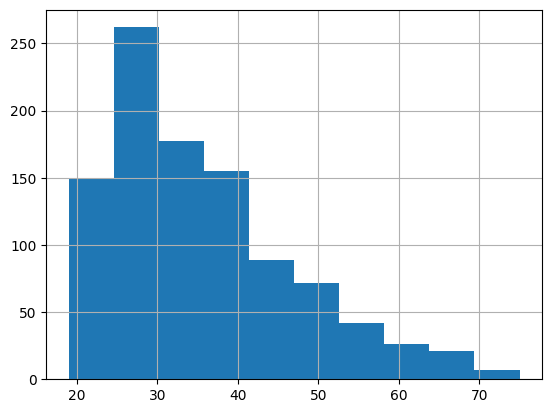

In [82]:
df['Age'].hist()

<Axes: >

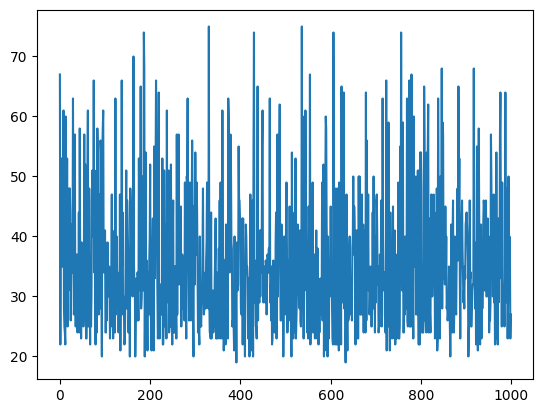

In [81]:
df['Age'].plot()

## 4. Домашнее задание  



1. Сколько мужчин и женщин (признак Sex) представлено в этом наборе данных?

In [86]:
df['Sex'].value_counts()

,count
Sex,
male,690
female,310


2. Каков средний возраст (признак Age) женщин?

In [88]:
print(df[df['Sex'] == 'female']['Age'].mean())


32.803225806451614


3. Какова доля заемщиков с собственным жильем (признак Housing)?

In [90]:
print((df['Housing'] == 'own').mean())

0.713


4. Каково среднее значение возраста тех, кто имеет высокие накопления (признак Saving_accounts)?

In [91]:
print(df[df['Saving_accounts'] == 'rich']['Age'].mean())

np.float64(37.166666666666664)

5. Каково среднеквадратичное отклонения возраста тех, кто имеет высокие накопления (признак Saving_accounts)?

In [ ]:
# Ваш код здесь

6. Выведите гистограмму категорий покупок (признак Purpose) для мужчин и женщин.

In [ ]:
# Ваш код здесь

7. На что чаще всего берутся длинные кредиты (более 24 мес)?

In [ ]:
# Ваш код здесь

8. Какой средний срок кредита (признак Duration) для заемщиков, имеющих высокие текущие траты (признак Checking_account)?

In [ ]:
# Ваш код здесь

9. Какой средний срок кредита (признак Duration) для заемщиков, имеющих низкие текущие траты (признак Checking_account)?

In [ ]:
# Ваш код здесь

10. На какую цель взят самый дорогой кредит?

In [ ]:
# Ваш код здесь